MIT License

Copyright (c) 2023 Justin Randall, Smart Interactive Transformations Inc.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# Overview

The main purpose of this notebook is as a helpful companion/tool for [a blog post](https://sitinc.net/2023/12/23/the-last-sectional-of-the-year/) by Smart Interactive Transformations Inc. around the SECTION Framework (TM) for functional requirements gathering for automating customer journeys.  Being able to dig into data and extract patterns and themes will help you create experiences whether they are based on rules-based regular expressions or Natural Language Processing (NLP) frameworks, Natural Language Understanding intent-classification models (NLUs), or Large Language Models (LLMs).

This notebook walks you through generating transcripts using OpenAI chat completions, then analyze clustering of utterances and common entities.  You can use this code to analyze real transcripts, but see my comments along the way to understand some things you might want to adjust or implement.  In most cases, I plan to implement these suggestions in the form of a feature behaviour at some point.

All underlying Python code necessary to run the notebook is included within this project for simplicity, but you can also import the packaged interactovery Python module from PyPI directly into your projects if you wish to re-use any of its components:


```bash
pip install interactovery
```


**Warning:**
The notebook uses the OpenAI chat completions API to generate example transcripts, and generate intent names for cluster groupings.  Please make sure to consult [OpenAI API Pricing](https://openai.com/pricing) to understand the costs associated with your executions.

I will add locally-run open source solutions for generating embeddings, generating transcripts, and naming clusters in the near future.

Once we get through the entire notebook, we'll have lots of great data to feed into the SECTION framework and make sure we have a clear view of the journeys whether new or up for improvement.

## Setting up the environment

Before you can run all the code in this notebook, you will need to configure your OpenAI API key and ORG ID in a local environment file, conf/dev.env:

```conf/dev.env
OPENAI_API_KEY=<Your OpenAI API Key>
OPENAI_ORG=<Your OpenAI Org ID>
```

Below I am loading the 'en_core_web_lg' language model.  After installing Python dependencies, you will need to manually download this language model.

```bash
python -m spacy download en_core_web_lg
```

If you with to use a different language model, ensure to download the desired model, and update the reference in the below cell.

In [1]:
from interactovery import Transcripts, Utterances, OpenAiWrap, VizWrap, WorkspaceManager

import spacy

from dotenv import load_dotenv
import os
from pathlib import Path

import logging.config

# Initialize the notebook environment.

# Key directories.
prj_root = os.path.join(os.getcwd(), '..')
conf_dir = os.path.join(prj_root, 'conf')
env_conf = os.path.join(conf_dir, 'dev.env')
workspace_root = os.path.join(prj_root, 'workspaces')

# Logger configuration.
logger_conf = os.path.join(conf_dir, 'logging.conf')
logger_name = 'notebookLogger'

logging.config.fileConfig(logger_conf)
log = logging.getLogger(logger_name)

# Environment variables.
env_path = Path(env_conf)
load_dotenv(dotenv_path=env_path)

# Initialize the OpenAI API Wrapper
openai_api_key = os.getenv('OPENAI_API_KEY')
openai_org = os.getenv('OPENAI_ORG')
openai_client = OpenAiWrap(
    openai_org,
    openai_api_key
)

# Initialize the spaCy language model
spacy_nlp = spacy.load('en_core_web_lg')

# Initialize the Transcript Processor
tss = Transcripts(
    openai=openai_client,
    spacy_nlp=spacy_nlp,
)

wm = WorkspaceManager(root_dir=workspace_root)
workspace = wm.create(name='test1')

# Generating Sample Transcripts

Here we will leverage the OpenAI chat completions API to generate transcripts.  The default model used is "gpt-4-1106-preview".  NOTE: This will incur usage-based-billing charges to your OpenAI API account.  You can change the model by adding the model="<model name>" to the gen_agent_transcripts function below.

**Warning:**
DO NOT MODIFY/RUN this cell if you aren't 100% confident you understand the [financial outcome of the change/execution](https://openai.com/pricing).  Increasing the number of transcripts will linearly increase cost, while adding more instructions has a multiple effect on token usage for the total number of requested transcripts.

The cell below will generate 5 transcripts for an executive assistant scheduling follow-up meetings.  The actual value used to generate the transcripts for the later cells (and for the blog entry relating to this notebook) was 500.  The transcripts are generated using UTF-8 encoding, and includes characters that don't encode in ASCII.

In [2]:
quantity = 5
user_prompt_gen_transcript = """The transcript should be of an executive assistant receiving calls for 
their executive and needing to schedule a follow-up at a later date.  Randomly decide on a date and time and how many 
turns it takes to book the appointment.  Randomly decide on people names, but make sure to use diverse names.  Don't 
use the words "my executive" or "your executive" or similar expressions.  Randomly decide on the reason the executive 
is unavailable.  Don't use an executive service as a business."""

tss.gen_agent_transcripts(
    user_prompt=user_prompt_gen_transcript,
    quantity=quantity,
    output_dir=workspace.transcripts_path,
)

'[########################################] 100.0% Generating transcripts'

# Analyzing the Transcripts

## Transcripts, Assemble!

After generating the transcripts into a folder, the next step is to combine them all into a single file to analyze further.  Here we'll convert the combined .txt transcript files to a single CSV, including the source file references.  We also want to separate multiple sentences by the same speaker instance into individual utterance lines.

The below code concatenates the transcript directory into a single file and maintains UTF-8 encoding.

In [3]:
utterance_csv_file = tss.concat_and_process_ts_to_csv(
    in_dir=workspace.transcripts_path,
    out_dir=workspace.ts_combined_path,
)

print(f'Combined files into {utterance_csv_file}')

'[########################################] 100.0% Assembling transcripts to CSV file'

Combined files into C:\Local\Dev\Workspaces\SIT\journey-discovery-getting-started\notes\..\workspaces\test97\transcripts-combined\transcripts_combined.csv


## Loading the Utterances

Now let's load the utterances from the CSV into an object for additional analysis.

In [2]:
df = Transcripts.get_combined_utterances(in_dir=workspace.ts_combined_path)
utterances_list = df['utterance'].tolist()

utterance_csv_path = os.path.join(workspace.ts_combined_path, 'transcripts_combined.csv')

user_utterances = Utterances(
    source=utterance_csv_path,
    utterances=utterances_list,
)

print(f"user_utterances: {user_utterances}")

user_utterances: Utterances(source=C:\Local\Dev\Workspaces\SIT\journey-discovery-getting-started\notes\..\workspaces\test1\transcripts-combined\transcripts_combined.csv, utterances=..., utterance_count=14577, unique_utterances=..., unique_utterance_count=9208, volume_utterance_count_map=...)


## Process and Cluster the Utterances

Preprocess the text, generate embeddings, and cluster the resulting data.

**Warning:**
DO NOT MODIFY/RUN this cell if you aren't 100% confident you understand the [financial outcome of the change/execution](https://openai.com/pricing).  The number of utterances within a cluster won't affect cost, as each chat completion request limits the cluster examples to 50.  The cost will increase based on the number of individually discovered clusters that each need to be named.

'[########################################] 100.0% Generating names for clusters'

2024-01-09 11:26:42 - transcriptLogger - INFO - 4526b8a7-e02a-4f38-837c-664f4a6fb470 | cluster_and_name_utterances | Visualizing clusters


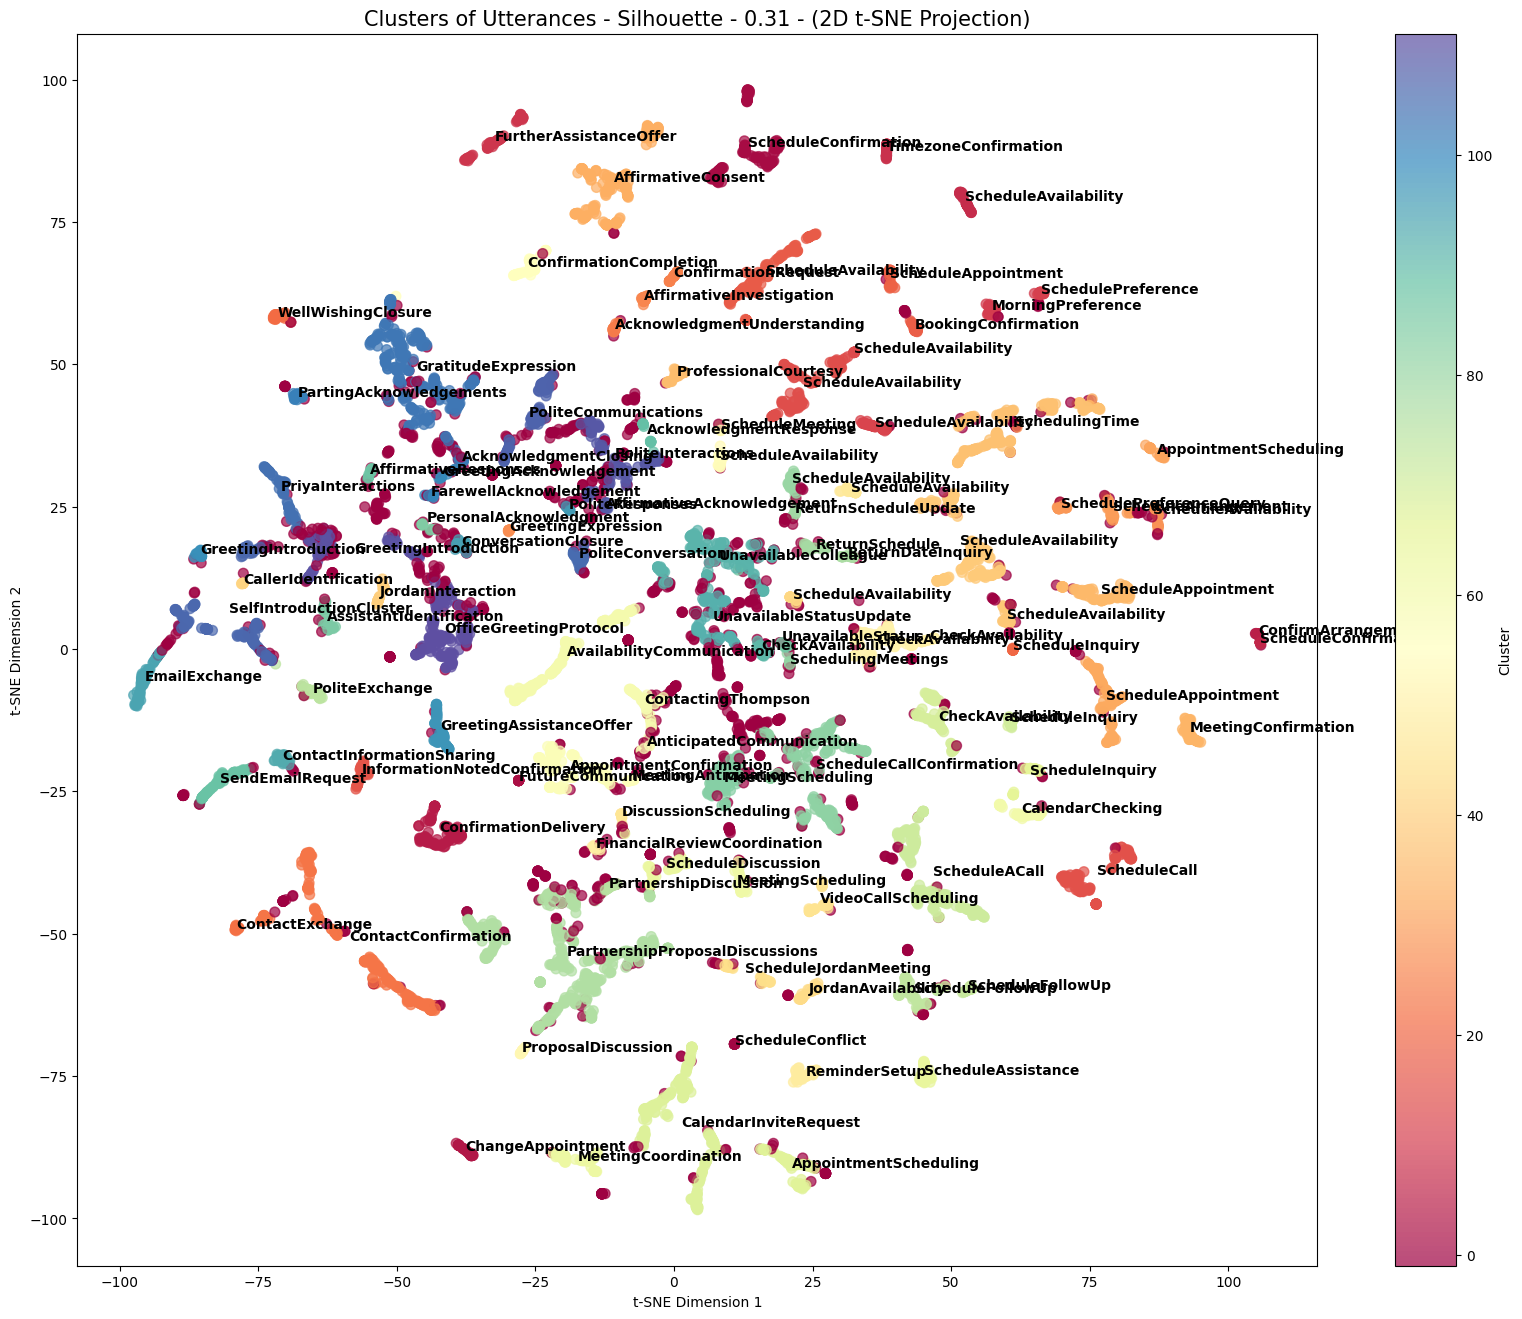

In [3]:
tss.cluster_and_name_utterances(
    workspace_dir=workspace.work_dir,
    utterances=user_utterances.unique_utterances,
    output_dir=workspace.intents_path,
    min_cluster_size=15,
)

# Analyzing Clusters of "could-be" Intents

Let's have a look at the resulting clusters reduced to 2D on a graph shown above.

This view might not be the easiest to interpret, especially with smaller clusters, but is worth having a look and considering experimenting with different models and parameters for dimensionality reduction, embeddings, and clustering until you are confident moving forward with the results.  What you would ultimately want here is that all scatter plots that are closer together are part of a cluster, and that there are little to no overlaps.  That's not the case above, and we can definitely improve on our clustering, but it's good enough for the use case at hand.  If you are tempted to use this data as NLU training data for intent classification, I'd avoid that.  This data is useful for ideating and requirements collection.  The better use of this data is the catalogue possible and likely intents to feed into design.  Many platforms have the ability to generate intents with synthesized training data, and it's quite simple to write your own code to do that if you're not using such a platform.

## Comparing Cluster Distributions and Noise

It helps to be able to see how much of the utterances were successfully grouped into a clusters vs. treated as noise.  By inspecting the distribution of unique utterances across all clusters and the noise group, we can decide if we need to revisit experimenting with dimensionality reduction, embeddings, and clustering to reduce noise.  Your data might simply result in high noise.

Below we can see 13.4% of utterances were considered noise.  Inspecting the file I do see plenty of utterances that belong to the clusters we've identified.  For our ideation to feed into the design phase, this is good enough to start.

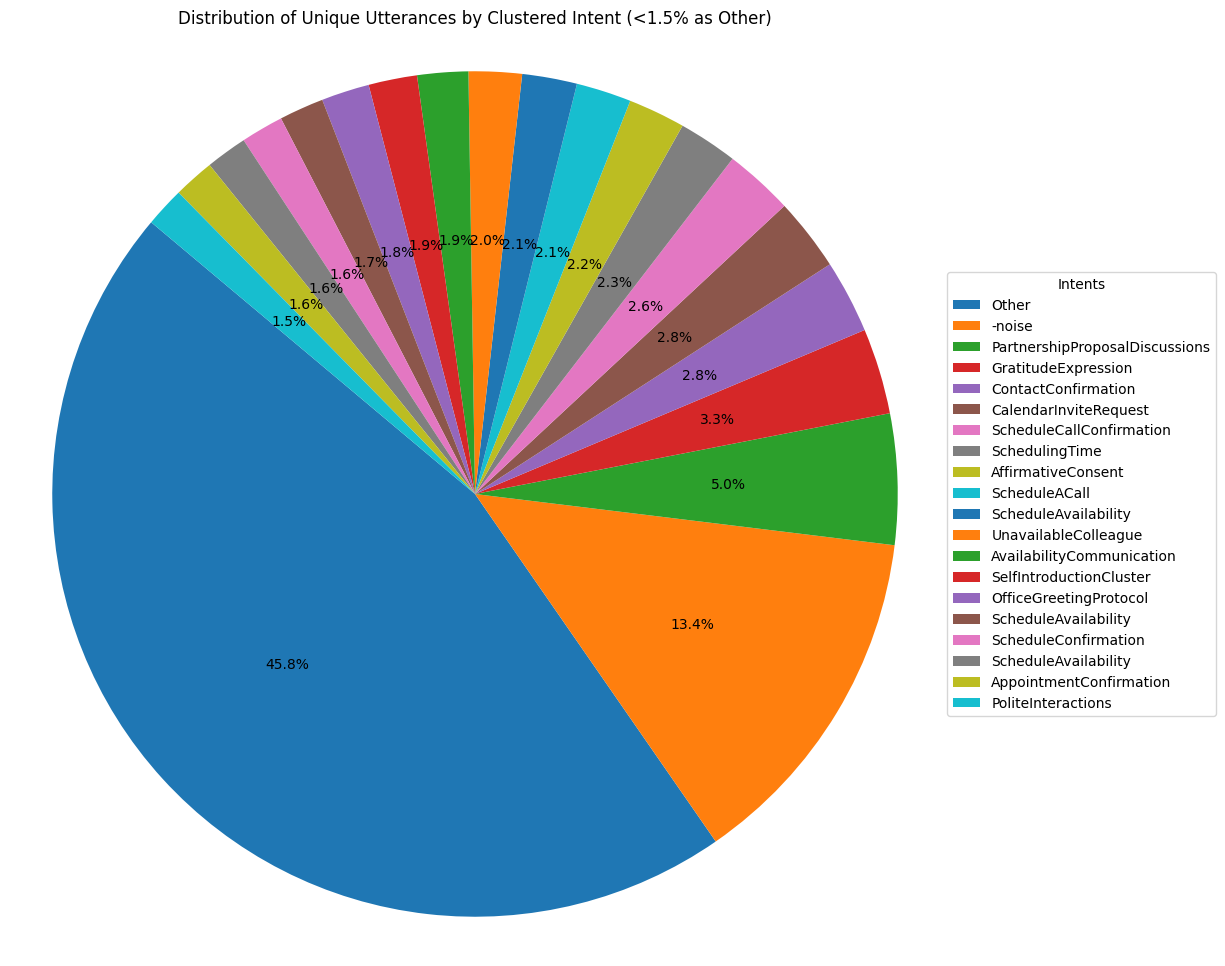

In [3]:
# View pie chart distribution, including cluster noise.
intent_pie_chart = Transcripts.get_intent_utterance_counts(
    directory=workspace.intents_path,
    incl_descr=False,
    incl_noise=True,
)
VizWrap.show_intent_pie(chart=intent_pie_chart,group_threshold=0.015)

## Utterance Distributions Across Clusters

Let's look at the distribution of utterances by cluster for all clusters and with improved descriptions.  Since we generated the transcript data, I wouldn't put much stock in the distribution of this data, but with real data, this data should help drive your use case priority map based on the things people are talking about.

Because I used a small minimize cluster size, it is highly likely many of these clusters can be merged.  When we're talking about 112 clusters (technically, 111 clusters and an extra group for noise), so verifying each and cleaning up and combining them is a relatively straightforward activity for those with conversation design or NLU expertise.  Because each cluster is output to a file, you can freely remove the things you think are wrong and place them into the noise file, then further process the noise file after cluster cleanup and try and use other techniques to match the noise to potential clusters.

It is likely never a good use of your time to manually clean up transcripts you've generated with AI, unless you're learning/experimenting or working on a project that specifically uses clustering to evaluate some aspects of how generative AI produces the content being clustered.  Spend the time cleaning up the clusters when working with real data so that you can have a more accurate representation of cluster sizes.  Note that the code shared in this notebook creates embeddings only on unique utterances, so make sure to use all utterances including duplicates when attempting to understand volumes of related utterances.

These clusters, cleaned-up or as-is, will be used to create our library of intents and reminders of things we may have forgotten to consider.

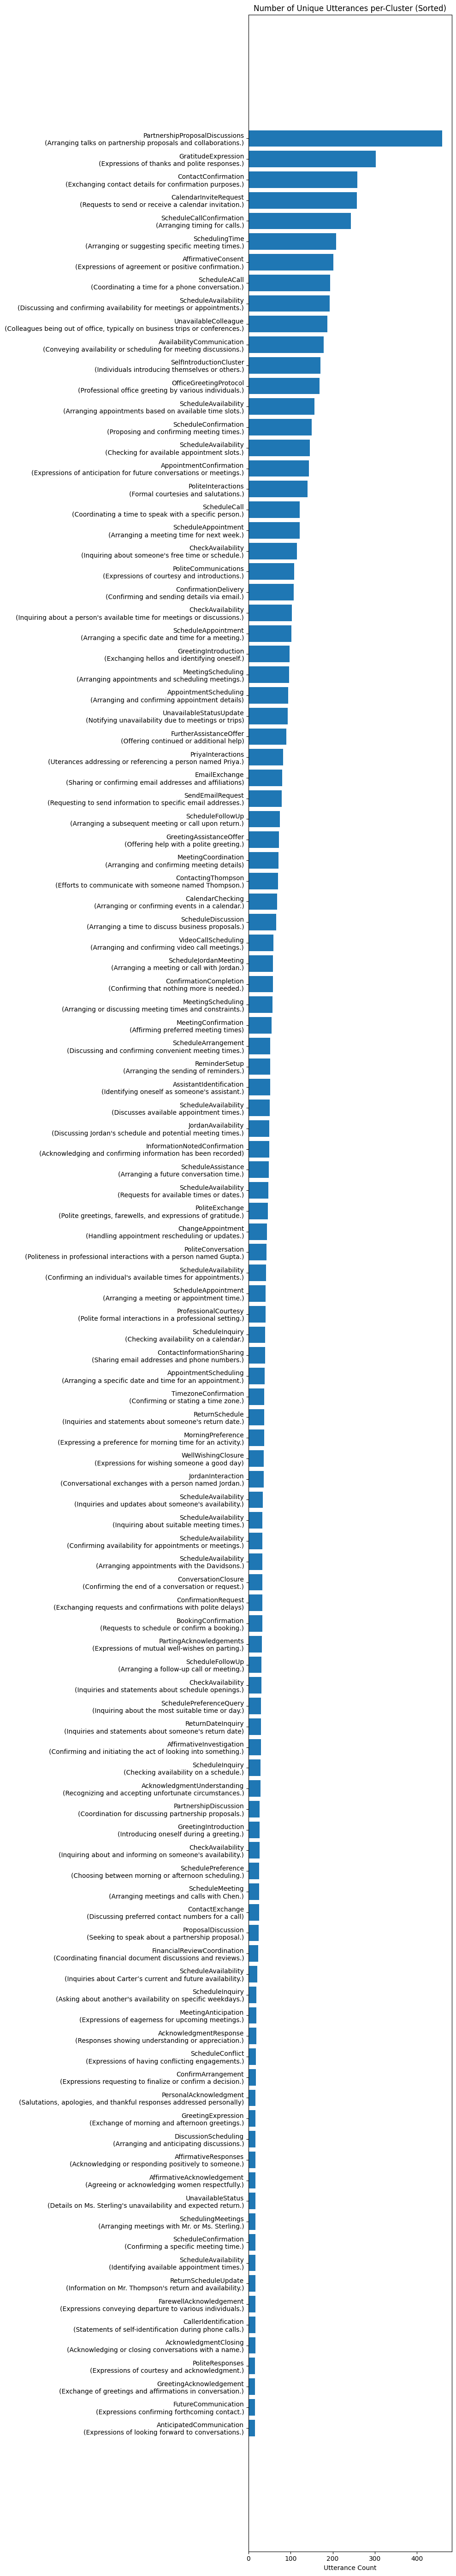

In [4]:
# View horizontal bar chart of utterance volume.
intent_bar_chart = Transcripts.get_intent_utterance_counts(
    directory=workspace.intents_path,
    incl_descr=True,
    incl_noise=False,
)
VizWrap.show_intent_bars(chart=intent_bar_chart)

# Analyzing Commonly Recognized Entities

## Extracting Entities
We also want to identify any known entities, or "things", that we will likely need to talk about.  Some types of entities can be far more complicated to work with than it seems at first glance.  For example, working with people names and street address, while totally doable, requires much more complexity through additional processing logic than using an NLU or LLM to parse them.

In [3]:
tss.extract_entities(df, workspace.entities_path)

'[########################################] 100.0%'

## Entity Example Count Distributions by Type

Alright.  Now let's see what types of entities we found.  I used spaCy under the hood for entity extraction, so the entity type names related directly to their built-in types.  Note that you can easily customize spaCy models with your own custom types as you refine the types of things you're interested in recognizing, particularly for domain-specific efforts.

Much like clustering utterances, entity extraction isn't perfect either.  It's helpful to visualize the distributions of entity value count by type to know which ones are really on the radar as likely to be necessary.

In the graph below, many of the smaller one were actually just people names that also happened to be locations, works of art, etc.

Really, for the telephone scheduling assistant, it makes a lot of sense that people names, times, dates, and companies are the only entity types that show significant representation.

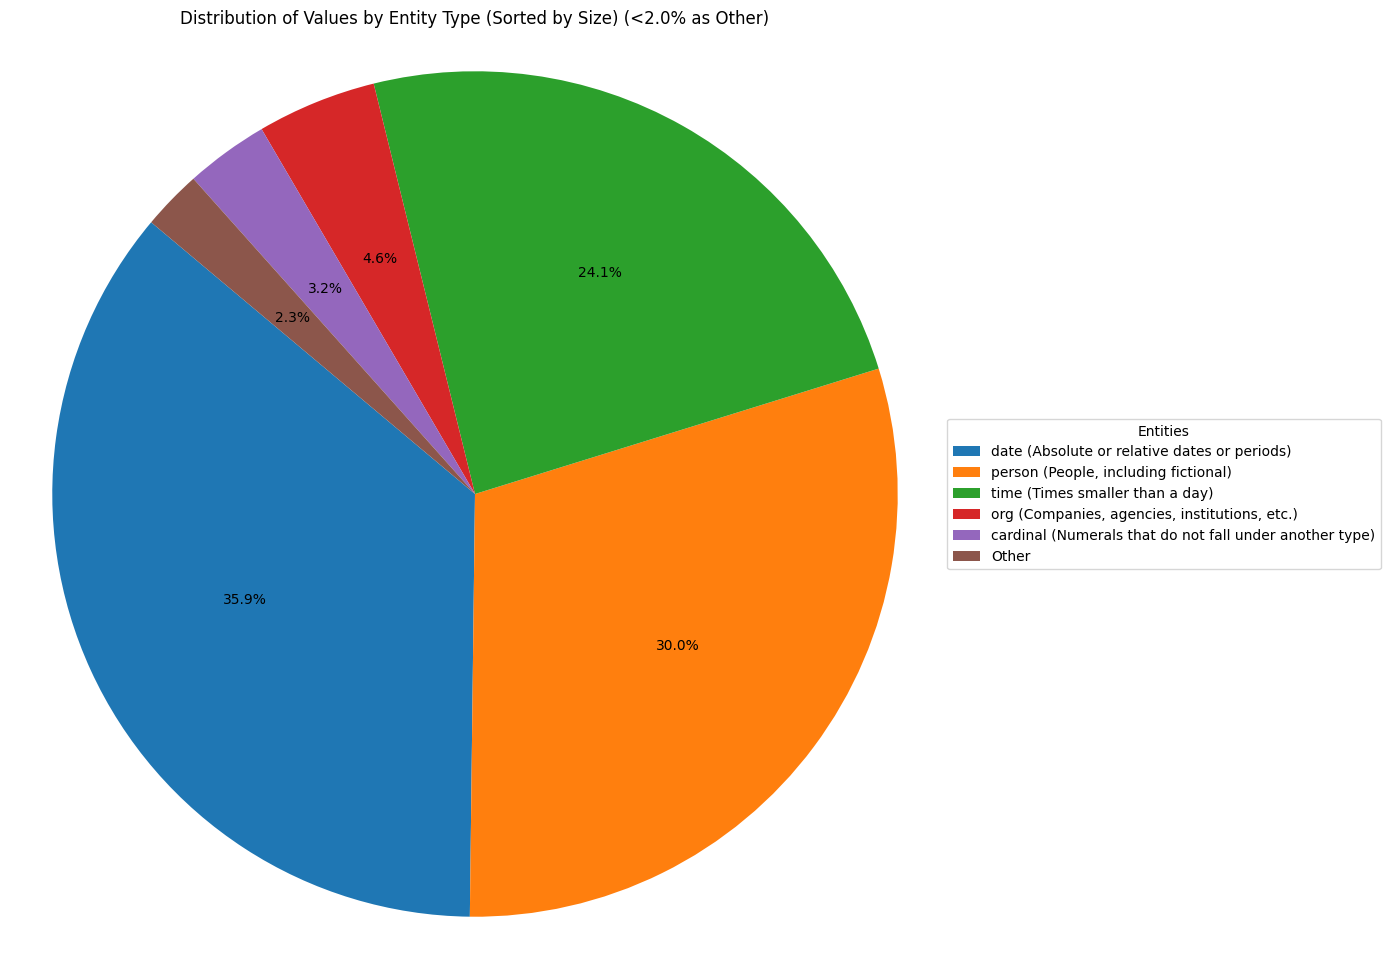

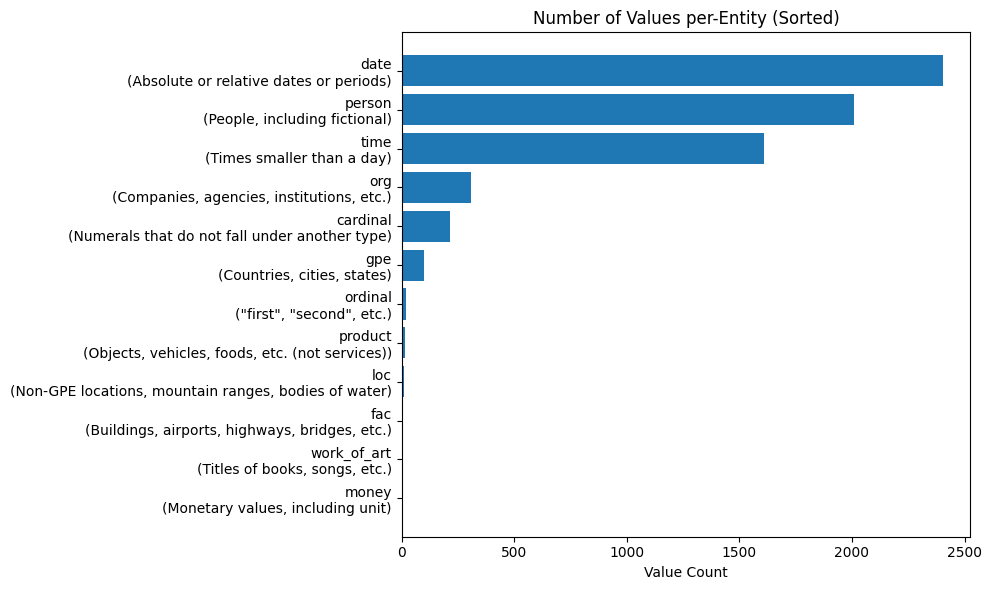

In [5]:
# View pie chart distribution, including cluster noise.
entity_pie_chart = Transcripts.get_entity_value_counts(
    directory=workspace.entities_path,
    incl_descr=True,
    descr_sep=' ',
)
VizWrap.show_entity_pie(chart=entity_pie_chart, group_threshold=0.02)

entity_bar_chart = Transcripts.get_entity_value_counts(
    directory=workspace.entities_path,
    incl_descr=True,
)
VizWrap.show_entity_bars(chart=entity_bar_chart)

With this, we've collected data for what people are saying and dig into some of the common important types of things people talk about in our generated use case.

I look forward to expanding and improving this notebook and the associated module code to help those that benefit from its use.

Now back to [the blog post](https://sitinc.net/2023/12/23/the-last-sectional-of-the-year/) to complete the rest of the SECTION framework.